In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [51]:
"""MUST CHANGE THESE VARIABLES BEFORE RUNNING THE SCRIPT:
Protein_type, either "transmembrane", "collagen" or "globular"
Residues_or_proteins, either "residues" or "proteins"""

protein_type = "globular"
residues_or_proteins = "proteins"
filename = 'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\Data\\data_for_all_dvd.csv'
data = pd.read_csv(f"{filename}", index_col=False)
data

KeyboardInterrupt: 

In [36]:
if protein_type == "transmembrane" and residues_or_proteins == "residues":
    # Remove globular proteins, using column "protein_contain_transmembrane"
    data = data[data["protein_contain_transmembrane"] == 1]
    # Remove variants in globular residues
    data = data[data["is_residue_transmembranal"] == 1]
    
if protein_type == "globular" and residues_or_proteins == "proteins":
    # Remove transmembrane proteins, using column "protein_contain_transmembrane"
    data = data[data["protein_contain_transmembrane"] == 0]
    # Remove variants in collagen residues, by the gene name
    data = data[~data["gene"].str.contains("COL")]

if protein_type == "collagen" and residues_or_proteins == "proteins":
    # Remove transmembrane proteins, using column "protein_contain_transmembrane"
    data = data[data["gene"].str.contains("COL")]

In [37]:
data = pd.get_dummies(data, columns=["secondary_structure"])

mapping = {"benign": 0, "pathogenic": 1}
data["pathogenicity"] = data["pathogenicity"].map(mapping)

data = data.drop(
    labels=["stability_delta", "sequence_length", "stability_WT", "stability_MUT", "hydrophobicity_WT", "hydrophobicity_MUT", "volume_WT",
            "volume_MUT", "oda_MUT", "oda_WT", "sasa_WT", "sasa_MUT", "RSA_MUT",
            "protein_contain_transmembrane", "is_residue_transmembranal", "aa_WT", "aa_MUT"], axis=1, inplace=False)

data

,gene,variant,pathogenicity,Absolute value of delta,blosum,hydrophobicity_delta,volume_delta,plddt_residue,opra_WT,opra_MUT,opra_delta,oda_delta,sasa_delta,RSA_WT,source,secondary_structure_Beta strand,secondary_structure_Helix,secondary_structure_Loop,secondary_structure_Turn
0,POLR1D,L111P,1,3.8370,-3,-5.4,-54.0,98.63,0.54,0.03,-0.51,2.37,-26.79,0.445445,dvd,False,True,False,False
1,POLR1D,T50I,1,1.3986,-1,5.2,50.6,96.03,-0.03,0.23,0.26,-2.22,37.23,0.653988,dvd,False,True,False,False
2,POLR1D,L55V,1,2.6009,1,0.4,-26.7,98.50,0.00,0.00,0.00,0.00,-0.01,0.000052,dvd,False,True,False,False
3,POLR1D,G99S,1,1.8862,0,-0.4,28.9,98.34,-0.02,0.00,0.02,-0.03,2.56,0.011237,dvd,False,True,False,False
4,POLR1D,C68W,1,34.9300,-2,-3.4,119.3,98.19,-0.40,-0.38,0.02,2.37,0.41,0.002838,dvd,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5465,FDXR,R301C,0,2.1830,-3,7.0,-64.9,98.45,-0.58,-0.40,0.18,-1.82,-14.80,0.142981,dvd,False,False,True,False
5469,PJVK,G292R,0,3.4270,-2,-4.1,113.3,40.81,-0.13,-0.61,-0.48,6.11,146.47,0.759278,dvd,False,False,True,False
5470,PJVK,R265C,0,0.3460,-3,7.0,-64.9,42.75,-0.40,0.22,0.62,-1.72,-110.68,0.821547,dvd,False,False,True,False
5471,PJVK,M260V,0,1.6350,1,2.3,-22.9,39.13,-0.82,-0.39,0.43,7.45,-31.74,0.484729,dvd,False,False,True,False


In [50]:
### Removing structural features ###

# structural_features = ["oda_delta", "stability_delta", "secondary_structure_Beta strand", "secondary_structure_Helix", "secondary_structure_Loop", "sasa_delta", "RSA_WT"]
# # Drop structural features
# data = data.drop(labels=["stability_delta"], axis=1, inplace=False)

In [39]:
data = data.drop(labels = ["source"], axis=1, inplace=False)
# data = data.drop(labels = ["position"], axis=1, inplace=False)


In [40]:
def get_mcc(tp, tn, fp, fn):
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc_score = numerator / denominator if denominator != 0 else 0
    return mcc_score

# Create list of all positions.
genes = data["gene"].unique()
tps = []
fps = []
fns = []
tns = []
errors = []
mistakes = 0

counter = 0

# Initiate a dataframe that will contain the predictions for each variant.
predictions_df = pd.DataFrame(columns=["gene", "variant", "prediction", "reality"])
predictions_df

,gene,variant,prediction,reality


In [41]:

for gene in genes:
    counter += 1
    print(f"Gene: {gene} ({counter}/{len(genes)})")
    # Create train and test sets.
    train = data[data["gene"] != gene]
    test = data[data["gene"] == gene]

    X_test = test.drop(labels=["pathogenicity", "gene", "variant"], axis=1, inplace=False)
    y_test = test["pathogenicity"]

    # Oversample the train set using SMOTE.
    X_train = train.drop(labels=["pathogenicity", "gene", "variant"], axis=1, inplace=False)
    y_train = train["pathogenicity"]
    oversample = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)
    # class_distribution = y_train_resampled.value_counts()
    # print(f"Training set: (SMOTE)\n{class_distribution}")

    xgb_classifier = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
    xgb_classifier.fit(X_train_resampled, y_train_resampled)  # Fit the model with the resampled data
    y_pred = xgb_classifier.predict(X_test)
    
    # Add the predictions to the predictions dataframe.
    # If there's more than one variant in the test set, add the predictions for all of them.if len(test) > 1:
    # If there's more than one variant in the test set, add the predictions for all of them.
    if len(test) > 1:
        predictions_df_gene = pd.DataFrame({
            "gene": test["gene"],
            "variant": test["variant"],
            "prediction": y_pred,
            "reality": test["pathogenicity"]
        })
        predictions_df = pd.concat([predictions_df, predictions_df_gene], ignore_index=True)
    else:
        # For a single variant, use the first prediction in y_pred
        if len(y_pred) > 0:
            predictions_df_single = pd.DataFrame({
                "gene": [test["gene"].values[0]],
                "variant": [test["variant"].values[0]],
                "prediction": [y_pred[0]],
                "reality": [test["pathogenicity"].values[0]]
            })
            predictions_df = pd.concat([predictions_df, predictions_df_single], ignore_index=True)

    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    fn = sum((y_test == 1) & (y_pred == 0))
    tn = sum((y_test == 0) & (y_pred == 0))

    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

    # print(f"tps: {sum(tps)}, fps: {sum(fps)}, fns: {sum(fns)}, tns: {sum(tns)}")

    print(f"Prediction: {y_pred}. Reality: {y_test.values}")
    
    # # print error if at least one prediction is wrong
    # if not np.array_equal(y_pred, y_test.values):
    #     print(f"Classification is wrong for position {pos}!")
    #     for i in range(len(y_pred)):
    #         if y_pred[i] != y_test.values[i]:
    #             mistakes+=1
    #             print(f"Predicted: {y_pred[i]}, reality: {y_test.values[i]}")

# Calculate MCC
TP = sum(tps)
FP = sum(fps)
FN = sum(fns)
TN = sum(tns)
mcc = get_mcc(TP, TN, FP, FN)

print(f"TP: {sum(tps)}, FP: {sum(fps)}, TN: {sum(tns)}, FN: {sum(fns)}")

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Results:")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"MCC: {mcc}")
print(f"Accuracy: {accuracy}")

Gene: POLR1D (1/123)
TP: 10, FP: 0, TN: 0, FN: 0
Prediction: [1 1 1 1 1 1 1 1 1 1]. Reality: [1 1 1 1 1 1 1 1 1 1]
Gene: NDP (2/123)
TP: 83, FP: 0, TN: 1, FN: 3
Prediction: [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0]. Reality: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0]
Gene: USH1G (3/123)
TP: 8, FP: 2, TN: 1, FN: 1
Prediction: [1 0 1 1 1 1 1 1 1 1 0 1]. Reality: [1 1 1 1 1 1 1 1 1 0 0 0]
Gene: OSBPL2 (4/123)
TP: 1, FP: 1, TN: 1, FN: 0
Prediction: [1 1 0]. Reality: [1 0 0]
Gene: ESRRB (5/123)
TP: 12, FP: 1, TN: 3, FN: 2
Prediction: [1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1]. Reality: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
Gene: FGF3 (6/123)
TP: 8, FP: 1, TN: 1, FN: 1
Prediction: [1 1 1 1 1 1 0 1 1 1 0]. Reality: [1 1 1 1 1 1 1 1

                   Predicted Pathogenic  Predicted Benign
Actual Pathogenic                  1338               352
Actual Benign                       170               451


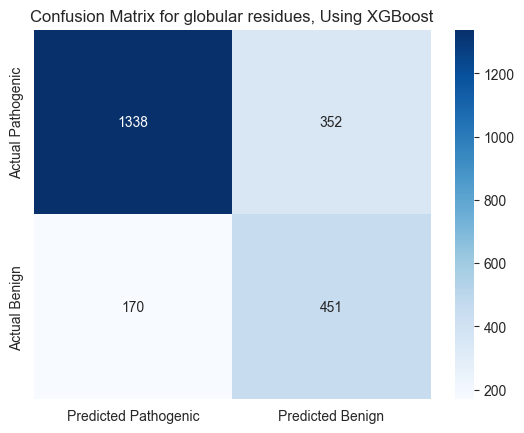

In [42]:
# Present the results in a confusion matrix, using TP, FP, FN, TN.
confusion_matrix = pd.DataFrame({"Predicted Pathogenic": [TP, FP], "Predicted Benign": [FN, TN]},
                                index=["Actual Pathogenic", "Actual Benign"])
print(confusion_matrix)

# Plot using seaborn, with light colors.
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.title(f"Confusion Matrix for {protein_type} residues, Using XGBoost")
plt.show()


In [43]:
data["gene"].unique()

array(['POLR1D', 'NDP', 'USH1G', 'OSBPL2', 'ESRRB', 'FGF3', 'TBX1',
       'SMPX', 'PAX1', 'ACTB', 'COCH', 'WHRN', 'SIX2', 'REST', 'NF2',
       'ATP6V1B1', 'SEMA3E', 'TJP2', 'AMMECR1', 'FOXI1', 'MAN2B1', 'MYO6',
       'POLR1B', 'MANBA', 'ERAL1', 'GIPC3', 'PEX1', 'HARS2', 'MYO7A',
       'CCDC50', 'DNMT1', 'POU3F4', 'ESPN', 'BTD', 'PRPS1', 'POU4F3',
       'NLRP3', 'CIB2', 'SOX10', 'MYO3A', 'LOXL3', 'LHX3', 'TNC', 'AIFM1',
       'TBC1D24', 'PDE1C', 'NEFL', 'GAB1', 'RDX', 'NR2F1', 'CDC14A',
       'POLR1C', 'PEX6', 'CEACAM16', 'DSPP', 'PAX3', 'TECTA', 'GRHL2',
       'ELMOD3', 'DCDC2', 'SNAI2', 'GPRASP2', 'TBL1X', 'CRYM', 'KARS1',
       'PPIP5K2', 'CEP78', 'MYH14', 'SUCLA2', 'LARS2', 'HOXB1', 'NOG',
       'TFAP2A', 'CLPP', 'WBP2', 'MASP1', 'DLX5', 'GRXCR1', 'DIAPH1',
       'MYH9', 'RAI1', 'SIX1', 'EYA4', 'GPSM2', 'DIABLO', 'GSDME', 'HGF',
       'USH1C', 'STRC', 'SIX5', 'TCOF1', 'MITF', 'PDZD7', 'ACTG1',
       'GATA3', 'OTOA', 'EDN3', 'LOXHD1', 'ATP6V1B2', 'PLS1', 'EYA1',
       '

In [44]:
predictions_df

,gene,variant,prediction,reality
0,POLR1D,L111P,1,1
1,POLR1D,T50I,1,1
2,POLR1D,L55V,1,1
3,POLR1D,G99S,1,1
4,POLR1D,C68W,1,1
...,...,...,...,...
2306,SERPINB6,V346I,0,0
2307,SERPINB6,G153S,1,0
2308,SERPINB6,M90V,1,0
2309,BDP1,V275I,0,0


In [45]:
# Check how many predictions were correct.
correct_predictions = predictions_df[predictions_df["prediction"] == predictions_df["reality"]]
# Calculate the accuracy of the model.
accuracy = len(correct_predictions) / len(predictions_df)

In [46]:
accuracy

0.7741237559498053

In [47]:
# Save the predictions to a file.
predictions_df.to_csv(f"C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\{protein_type}_{residues_or_proteins}\\predictions_vs_real_{protein_type}_{residues_or_proteins}.csv", index=False)

In [48]:
# Calculate per-protein accuracy, and save each protein's accuracy to a file.
proteins = predictions_df["gene"].unique()
accuracies = []
for protein in proteins:
    protein_df = predictions_df[predictions_df["gene"] == protein]
    correct_predictions = protein_df[protein_df["prediction"] == protein_df["reality"]]
    accuracy = len(correct_predictions) / len(protein_df)
    accuracies.append(accuracy)
    print(f"Accuracy for protein {protein}: {accuracy}")


Accuracy for protein POLR1D: 1.0
Accuracy for protein NDP: 0.9655172413793104
Accuracy for protein USH1G: 0.75
Accuracy for protein OSBPL2: 0.6666666666666666
Accuracy for protein ESRRB: 0.8333333333333334
Accuracy for protein FGF3: 0.8181818181818182
Accuracy for protein TBX1: 0.5555555555555556
Accuracy for protein SMPX: 1.0
Accuracy for protein PAX1: 0.6363636363636364
Accuracy for protein ACTB: 0.9459459459459459
Accuracy for protein COCH: 0.9
Accuracy for protein WHRN: 0.5789473684210527
Accuracy for protein SIX2: 0.5
Accuracy for protein REST: 0.8571428571428571
Accuracy for protein NF2: 0.8857142857142857
Accuracy for protein ATP6V1B1: 0.8888888888888888
Accuracy for protein SEMA3E: 0.625
Accuracy for protein TJP2: 0.625
Accuracy for protein AMMECR1: 1.0
Accuracy for protein FOXI1: 0.5454545454545454
Accuracy for protein MAN2B1: 0.7580645161290323
Accuracy for protein MYO6: 0.5666666666666667
Accuracy for protein POLR1B: 0.6666666666666666
Accuracy for protein MANBA: 0.583333333

In [49]:
# Calculate per-protein metrics, and save each protein's metrics to a file.
proteins = predictions_df["gene"].unique()
metrics = pd.DataFrame(columns=["gene", "sensitivity", "specificity", "precision", "accuracy", "mcc", "num_variants", "num_benign", "num_pathogenic"])
for protein in proteins:
    protein_df = predictions_df[predictions_df["gene"] == protein]
    TP = sum(protein_df["prediction"] & protein_df["reality"])
    FP = sum((protein_df["reality"] == 0) & (protein_df["prediction"] == 1))
    FN = sum((protein_df["reality"] == 1) & (protein_df["prediction"] == 0))
    TN = sum((protein_df["reality"] == 0) & (protein_df["prediction"] == 0))
    # to not divide by zero, check if there are any true positives, false positives, false negatives, or true negatives.
    if TP == 0:
        sensitivity = 0
        precision = 0
    else:
        sensitivity = TP / (TP + FN)
        precision = TP / (TP + FP)
    if TN == 0:
        specificity = 0
    else:
        specificity = TN / (TN + FP)
    mcc = get_mcc(TP, TN, FP, FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    protein_metrics = pd.DataFrame({
        "gene": [protein],
        "sensitivity": [sensitivity],
        "specificity": [specificity],
        "precision": [precision],
        "accuracy": [accuracy],
        "mcc": [mcc]
    })
    protein_metrics["num_variants"] = len(protein_df)
    protein_metrics["num_benign"] = sum(protein_df["reality"] == 0)
    protein_metrics["num_pathogenic"] = sum(protein_df["reality"] == 1)
    # add TP, FP, FN, TN to the dataframe
    protein_metrics["TP"] = TP
    protein_metrics["FP"] = FP
    protein_metrics["FN"] = FN
    protein_metrics["TN"] = TN
    metrics = pd.concat([metrics, protein_metrics], ignore_index=True)
    # add the number of variants for each protein
    
metrics.to_csv(f"C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\{protein_type}_{residues_or_proteins}\\metrics_{protein_type}_{residues_or_proteins}.csv", index=False)

C:\Users\InbarBlech\AppData\Local\Temp\ipykernel_22724\1621015253.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, protein_metrics], ignore_index=True)
